Control type: zero
True alpha: 1
True c: 1
Estimated alpha: 0.9999998297098458
Estimated c: 0.9999998919585433


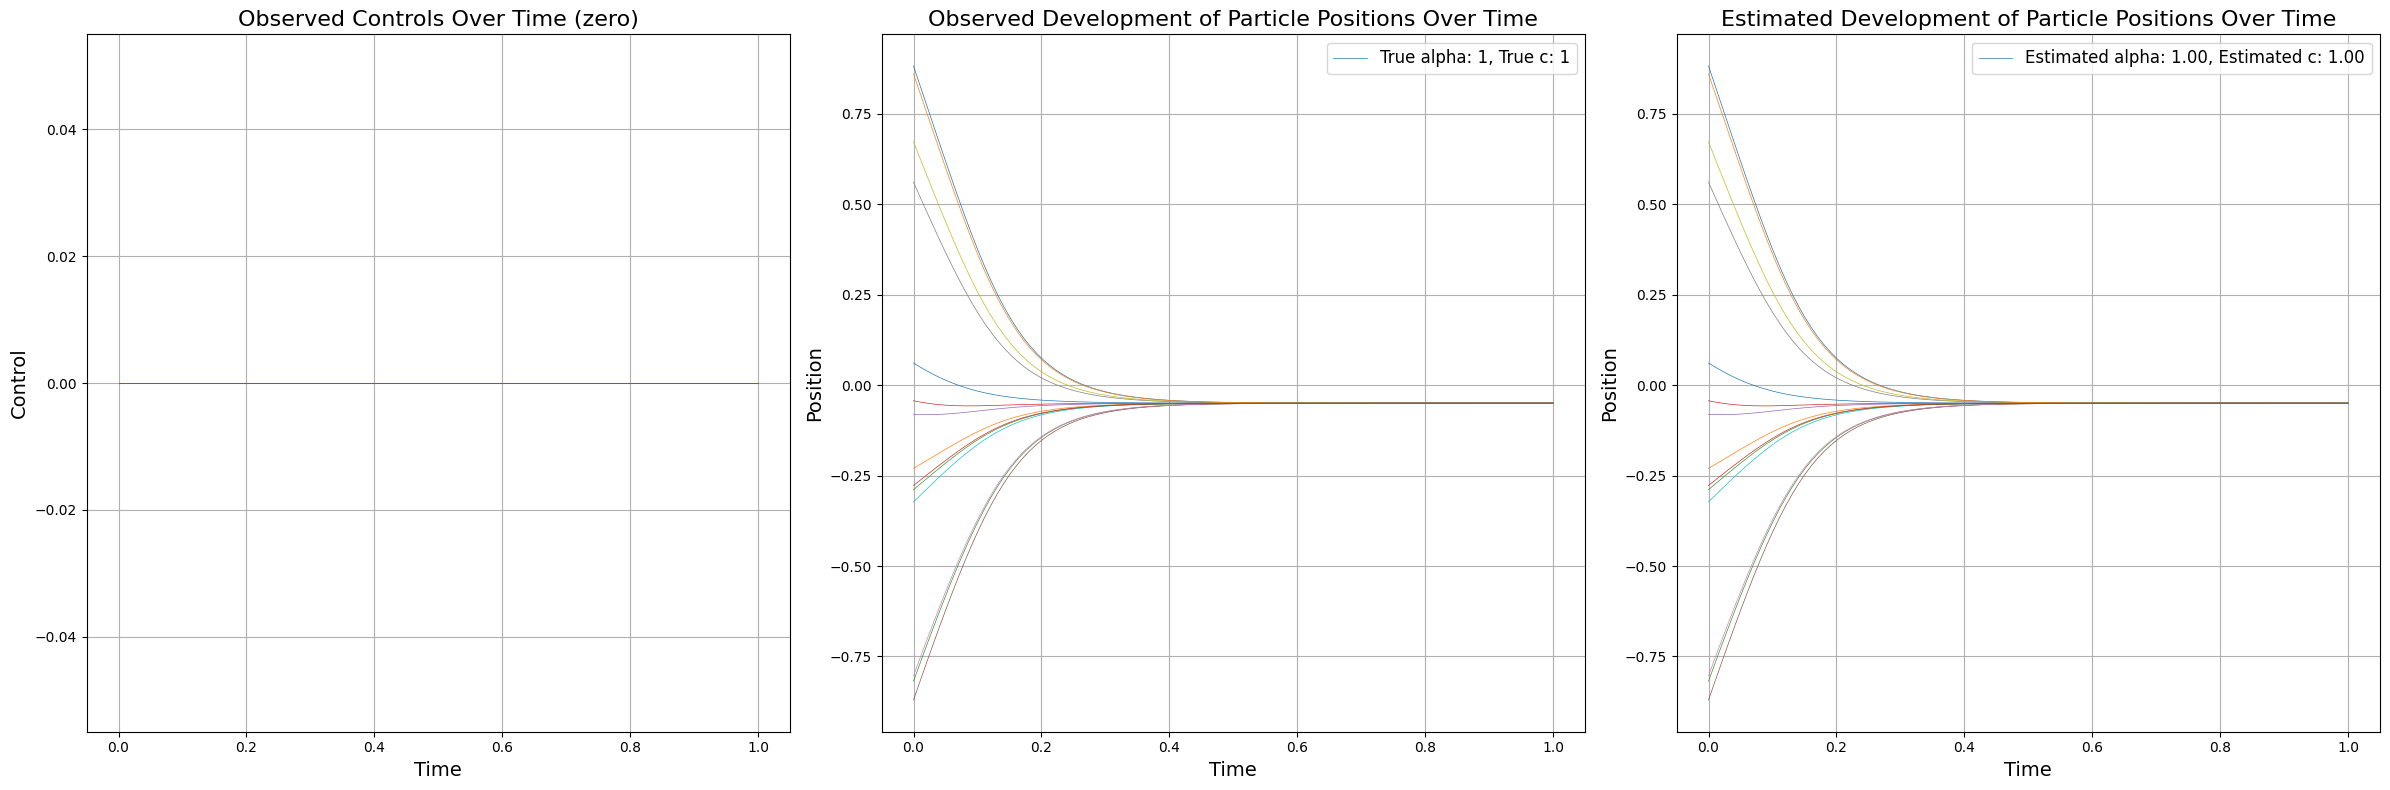

Control type: one
True alpha: 1
True c: 1
Estimated alpha: 0.9999998297018595
Estimated c: 0.9999998919584989


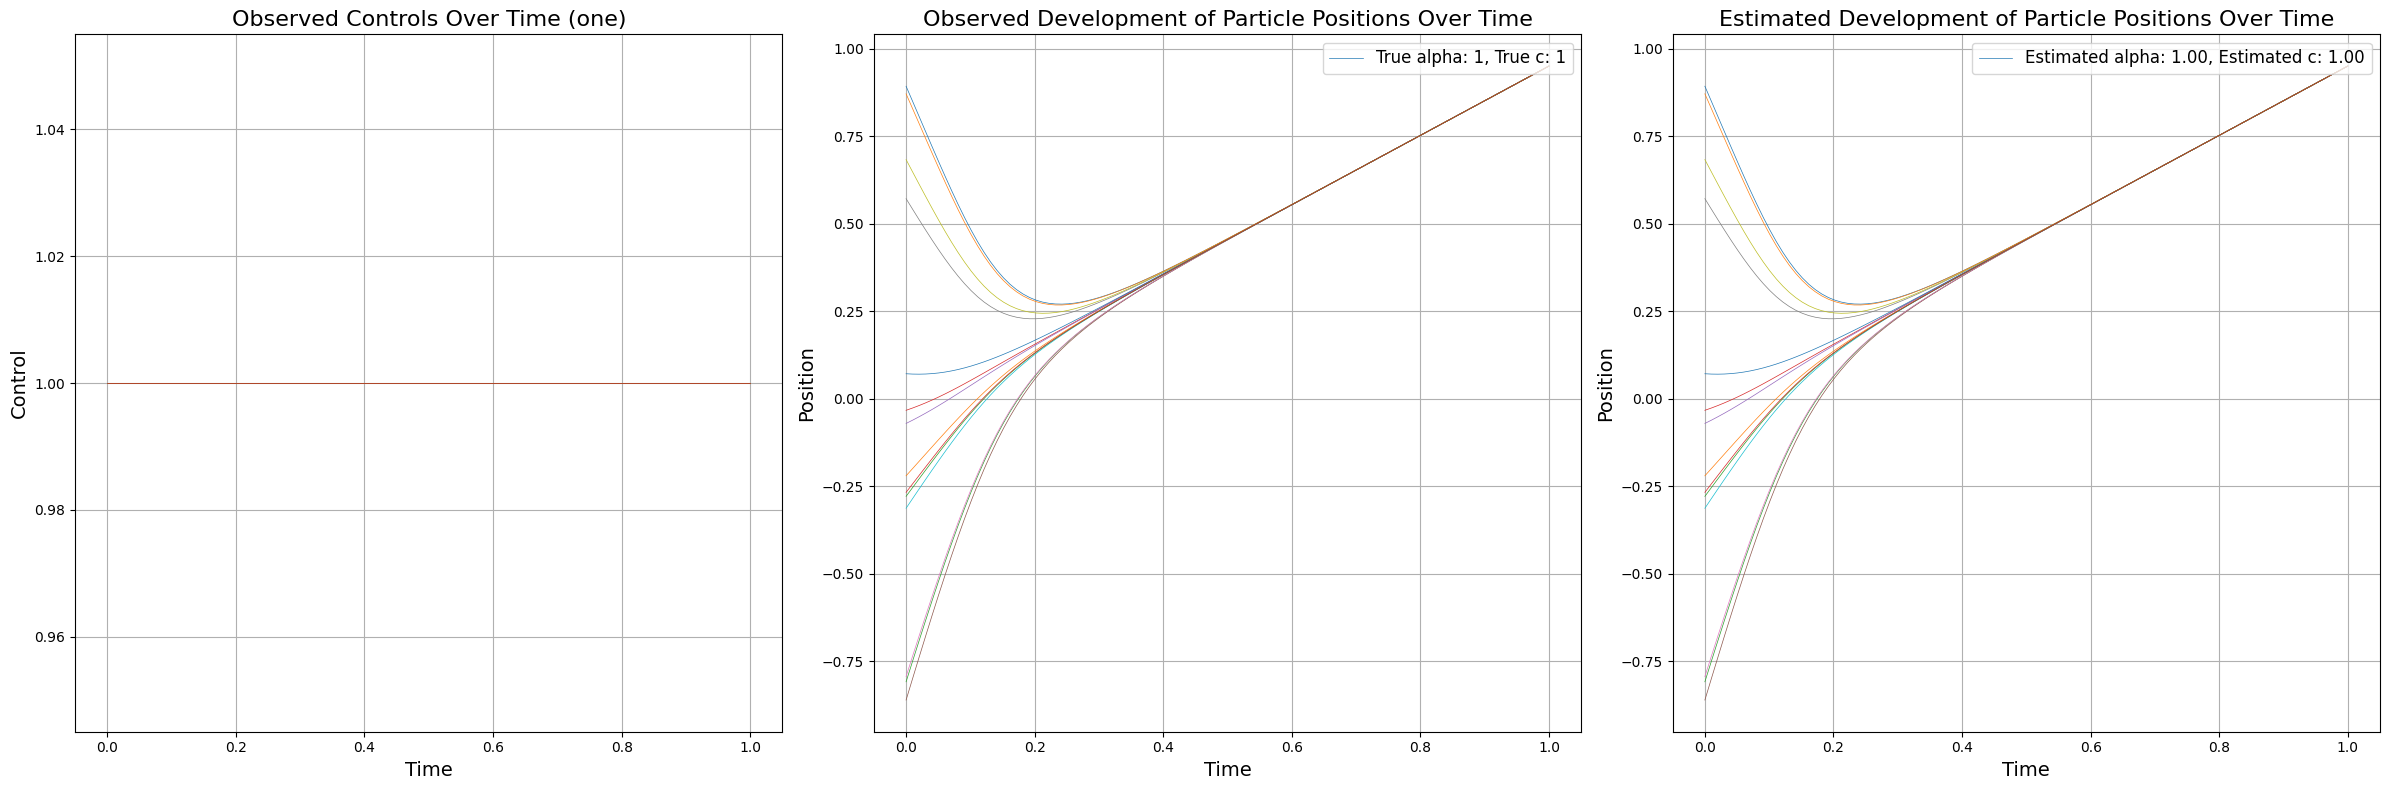

Control type: gaussian
True alpha: 1
True c: 1
Estimated alpha: 0.999999357162035
Estimated c: 0.9999996467433576


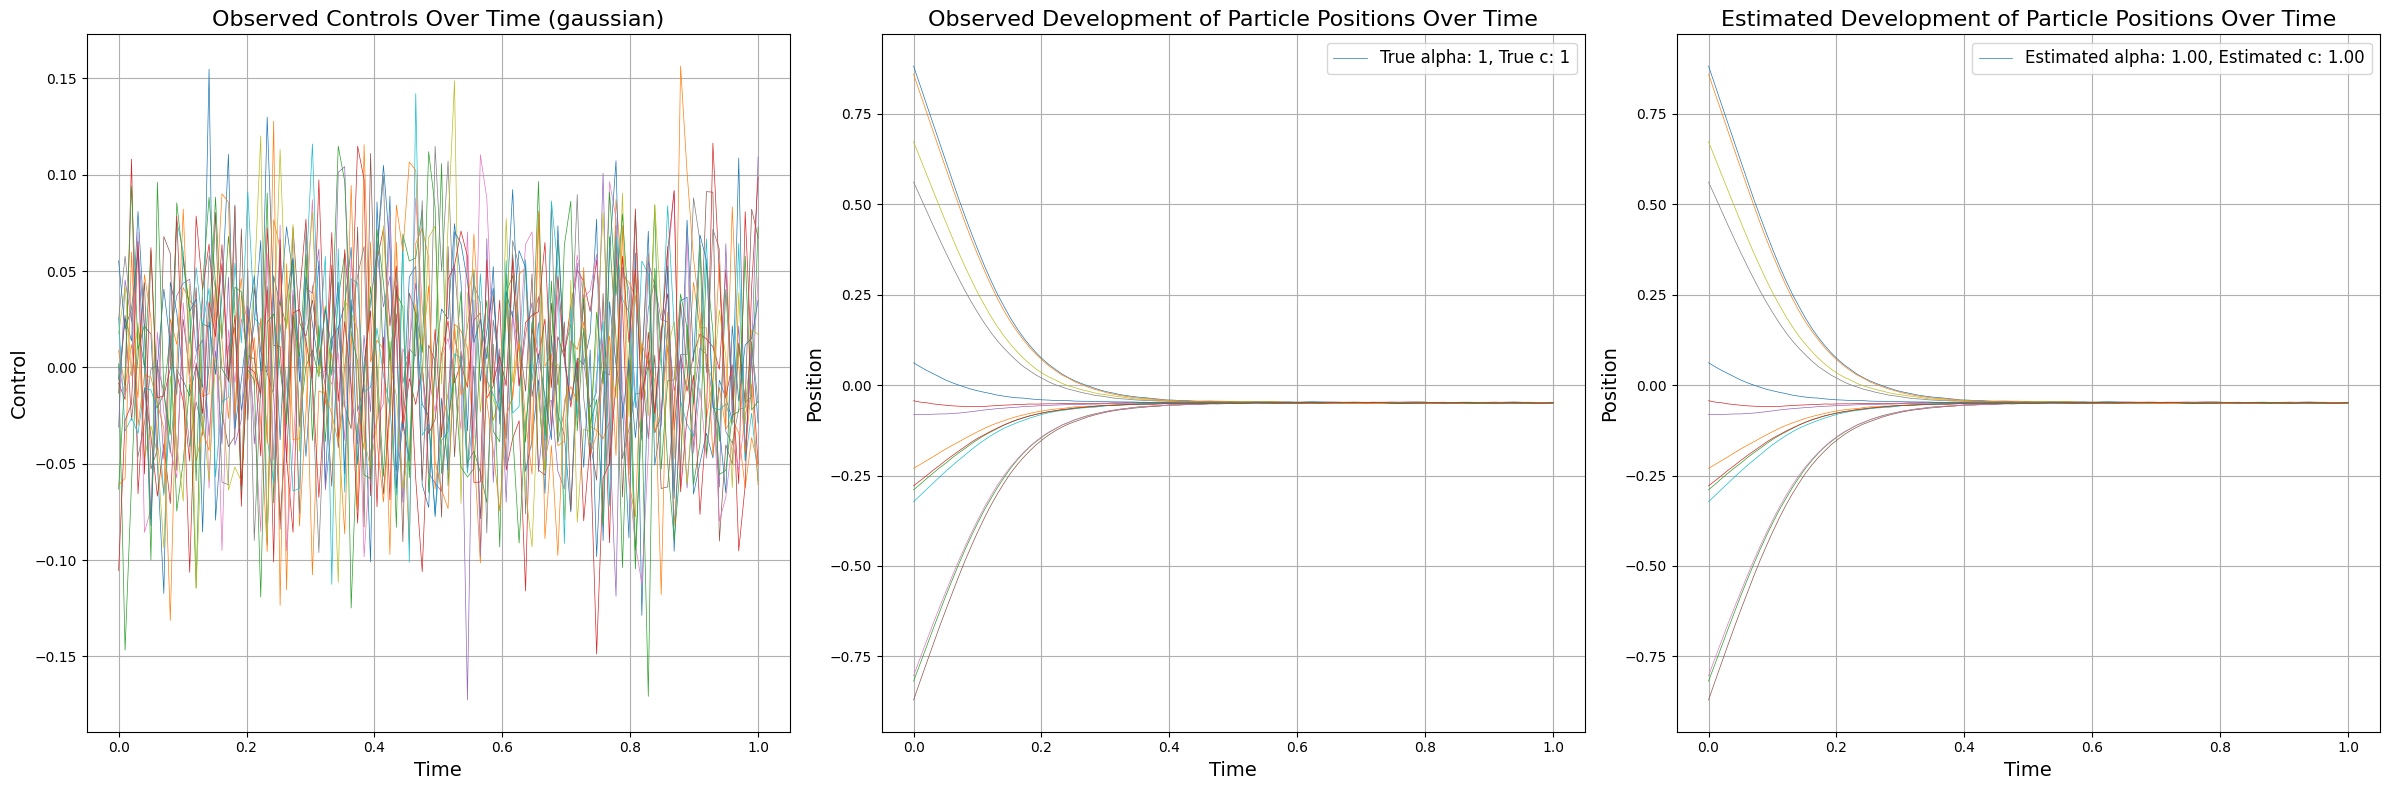

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Number of particles
N = 14

# Time parameters
t_start = 0
t_end = 1
dt = 0.01
time_steps = int((t_end - t_start) / dt)

# Define true parameters
true_alpha = 1
true_c = 1

# Generate initial positions uniformly sampled from [-1, 1]
initial_positions = np.random.uniform(-1, 1, N)

# Function to compute forces
def compute_forces(positions, alpha, c, controls):
    """
    Compute the forces acting on each particle given their positions, parameters (theta = (alpha, c)), and control values.

    Args:
        positions (list of float): A list of length N representing the positions of the particles at time t.
        alpha (float): A parameter of the CS kernel.
        c (float): A parameter of the CS kernel.
        controls (list of float): A list of length N representing the control values at time t.

    Returns:
        list of float: A list of length N representing the forces acting on each particle at time t.
    """

    forces = np.zeros_like(positions)
    for i in range(N):
        for j in range(N):
            if i != j:
                distance = positions[j] - positions[i]
                forces[i] += (distance * c) / ((np.abs(distance) ** 2 + 1) ** alpha)
    
    forces += controls
    return forces

# Runge-Kutta 4th order method
def rk4_step(positions, alpha, c, controls, dt):
    """Computes the next positions of the particles using the Runge-Kutta 4th order method

    Args:
        positions (list of float): A list of length N representing the positions of the particles at time t.
        alpha (float): A parameter of the CS kernel.
        c (float): A parameter of the CS kernel.
        controls (list of float): A list of length N representing the control values at time t.
        dt (float): time step

    Returns:
       positions (list of float): A list of length N representing the positions of the particles at time t + dt.
    """
    k1 = compute_forces(positions, alpha, c, controls)
    k2 = compute_forces(positions + 0.5 * dt * k1, alpha, c, controls)
    k3 = compute_forces(positions + 0.5 * dt * k2, alpha, c, controls)
    k4 = compute_forces(positions + dt * k3, alpha, c, controls)
    return positions + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def likelihood(params, observed_data, initial_positions, dt, controls):
    """Computes the negative log-likelihood of the noisy data given the parameters, as described in Chapter 2 of the report

    Args:
        params (list of float of length 2): (alpha, c)
        observed_data (N x (K+1) matrix of floats): The observed data, where N is the number of particles and K is the number of time steps.
        initial_positions (list of float): positions at time 0
        dt (float): time step
        controls ((N x (K+1) matrix of floats)): observed controls over time for each particle

    Returns:
        D: the discrepanct between the observed data and the data generated by the model with the given parameters as described in the report
    """
    alpha, c = params
    positions = initial_positions.copy()
    time_steps, N = observed_data.shape
    log_likelihood = 0
    
    for t in range(time_steps):
        positions = rk4_step(positions, alpha, c, controls[t], dt)
        log_likelihood += np.sum((observed_data[t] - positions) ** 2)
        
    return log_likelihood  # Negative log-likelihood for minimization

def plot_results(controls, positions_over_time, estimated_positions_over_time, true_alpha, true_c, estimated_alpha, estimated_c, control_type):
    """ 
    function for plotting the results for different control types
    """
    time = np.linspace(t_start, t_end, time_steps)
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    
    # Plot controls
    for i in range(N):
        axs[0].plot(time, controls[:, i], linewidth=0.5)
    axs[0].set_xlabel('Time', fontsize=14)
    axs[0].set_ylabel('Control', fontsize=14)
    axs[0].set_title(f'Observed Controls Over Time ({control_type})', fontsize=16)
    axs[0].grid(True)
    
    # Plot true positions
    for i in range(N):
        axs[1].plot(time, positions_over_time[:, i], linewidth=0.5)
    axs[1].set_xlabel('Time', fontsize=14)
    axs[1].set_ylabel('Position', fontsize=14)
    axs[1].set_title('Observed Development of Particle Positions Over Time', fontsize=16)
    axs[1].legend([f'True alpha: {true_alpha}, True c: {true_c}'], loc='upper right', fontsize=12)
    axs[1].grid(True)
    
    # Plot estimated positions
    for i in range(N):
        axs[2].plot(time, estimated_positions_over_time[:, i], linewidth=0.5)
    axs[2].set_xlabel('Time', fontsize=14)
    axs[2].set_ylabel('Position', fontsize=14)
    axs[2].set_title('Estimated Development of Particle Positions Over Time', fontsize=16)
    axs[2].legend([f'Estimated alpha: {estimated_alpha:.2f}, Estimated c: {estimated_c:.2f}'], loc='upper right', fontsize=12)
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

def run_simulation(control_type, control_value=None, sigma=None):
    """ finds the estimated parameters of a CS-type kernel for different control types

    Args:
        control_type (sting): 'zero', 'one', or 'gaussian' for different control types
        control_value (float): can be used to test gaussian controls with mean different from 0. Defaults to None.
        sigma (float, optional): standard deviation for gaussian type controls. Defaults to None.

    """
    # Set the controls
    if control_type == 'zero':
        controls = np.zeros((time_steps, N))
    elif control_type == 'one':
        controls = np.ones((time_steps, N))
    elif control_type == 'gaussian':
        controls = np.random.normal(control_value, sigma, (time_steps, N))
    else:
        raise ValueError("Unknown control type")

    # Initialize an array to store positions over time
    positions_over_time = np.zeros((time_steps, N))

    # Reset initial positions
    positions = initial_positions.copy()

    # Time evolution with position recording
    for t in range(time_steps):
        positions = rk4_step(positions, true_alpha, true_c, controls[t], dt)
        positions_over_time[t] = positions

    # Perform the optimization
    result = minimize(likelihood, [2, 0.5], args=(positions_over_time, initial_positions, dt, controls), bounds=[(0.1, 10), (0, 10)])

    estimated_alpha, estimated_c = result.x
    print(f'Control type: {control_type}')
    print(f'True alpha: {true_alpha}')
    print(f'True c: {true_c}')
    print(f'Estimated alpha: {estimated_alpha}')
    print(f'Estimated c: {estimated_c}')

    positions = initial_positions.copy()
    estimated_positions_over_time = np.zeros((time_steps, N))

    # Time evolution with position recording
    for t in range(time_steps):
        positions = rk4_step(positions, estimated_alpha, estimated_c, controls[t], dt)
        estimated_positions_over_time[t] = positions

    plot_results(controls, positions_over_time, estimated_positions_over_time, true_alpha, true_c, estimated_alpha, estimated_c, control_type)

# Run simulations for different control types
run_simulation('zero')
run_simulation('one')
run_simulation('gaussian', control_value=0, sigma=0.05)

